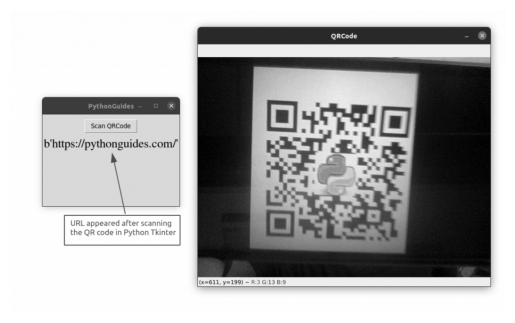

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

src = cv2.imread('C:\\study\\openCV\\qrcode.png')

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

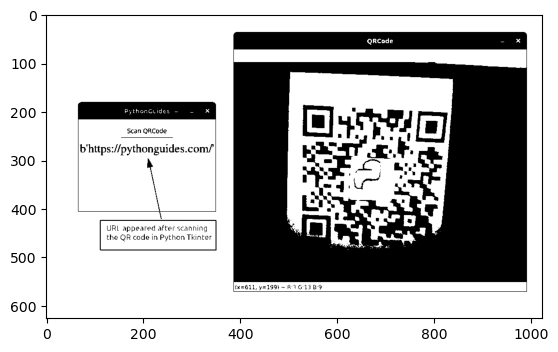

In [10]:
bin = (gray > 140).astype(np.uint8)
plt.imshow(bin * 255, cmap='gray')

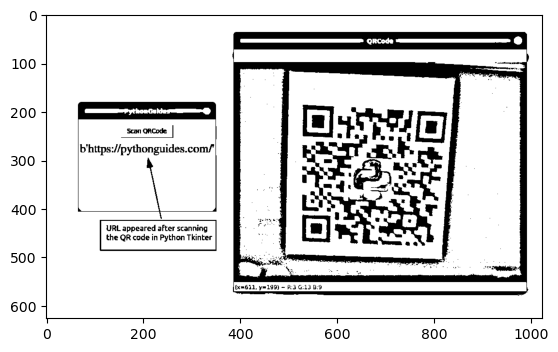

In [11]:
bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 10.0)
plt.imshow(bin * 255, cmap='gray')

In [12]:
bin.dtype

dtype('uint8')

In [ ]:
contours, hierarchy = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(contours) #immutable -> mutable
hierarchy = hierarchy[0] # (1, N, 4) -> (N, 4)

In [14]:
contours[0].shape

(4, 1, 2)

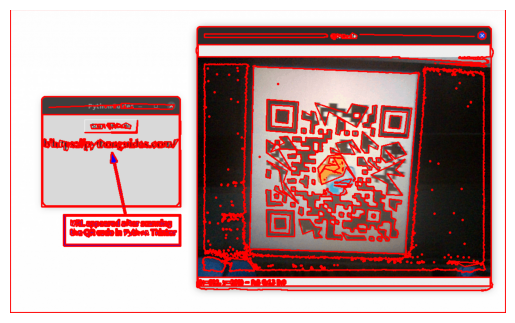

In [23]:
dst = src.copy()
for i in range(len(contours)):
    cv2.drawContours(dst, contours, i, (255, 0, 0), 2)

plt.imshow(dst)
plt.axis('off')
plt.show()

In [19]:
scores = [70, 80, 60]
names = ['김', '홍', '박']
# for name in names:
#     print(name)

# for score in scores:
#     print(score)

for name, score in zip(names, scores):
    print(name, score)

list(zip(scores, names))

김 70
홍 80
박 60


[(70, '김'), (80, '홍'), (60, '박')]

In [20]:
indies = range(len(names))

for i, name in zip(indies, names):
    print(i, name)

for i, (name, score) in enumerate(zip(names, scores)):
    print(i, name, score)


0 김
1 홍
2 박
0 김 70
1 홍 80
2 박 60


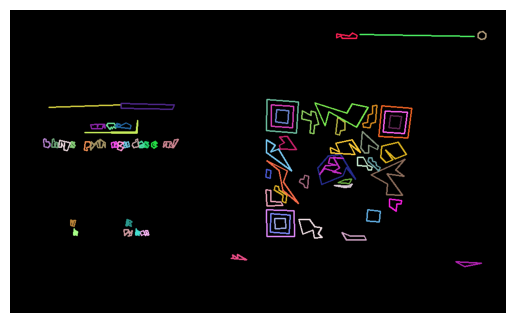

In [49]:
import random

dst = np.zeros(src.shape, dtype=np.uint8)
filtered_index = []

# for index in range(len(contours)):
#     contour = contours[index]
#     hie = hierarchy[index]

for index, (contour, hie) in enumerate(zip(contours, hierarchy)):
    arclen = cv2.arcLength(contour, True)
    if arclen > 500:
        continue
    if arclen < 50:
        continue
    eps = arclen * 0.03
    ap_contour = cv2.approxPolyDP(contour, eps, True)
    contours[index] = ap_contour

    filtered_index.append(index)

    color = np.random.randint(30, 256, [3]).tolist()
    cv2.drawContours(dst, contours, index, color, 2)

plt.imshow(dst)
plt.axis('off')
plt.show()

In [50]:
filtered_index

[9,
 23,
 32,
 36,
 69,
 71,
 80,
 82,
 83,
 86,
 89,
 92,
 93,
 94,
 96,
 98,
 99,
 102,
 105,
 107,
 109,
 112,
 115,
 118,
 119,
 123,
 271,
 318,
 376,
 393,
 419,
 420,
 421,
 429,
 442,
 445,
 452,
 464,
 468,
 470,
 472,
 479,
 480,
 482,
 483,
 485,
 496,
 501,
 503,
 504,
 506,
 508,
 516,
 519,
 522,
 523,
 524,
 525,
 527,
 531,
 532,
 533,
 581,
 585,
 590]

In [52]:
cv2.minAreaRect(contours[0])

((511.5, 312.5), (625.0, 1023.0), -90.0)

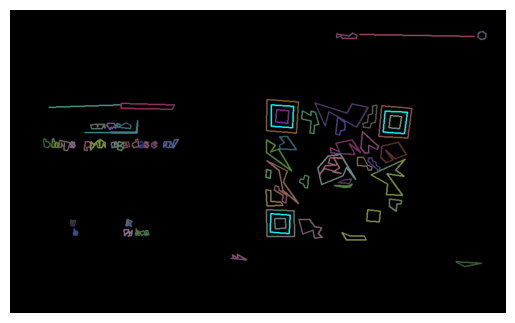

In [90]:
# QR코드 구조 이해
# QR코드 3개 모서리에는 3겹 정사각형 패턴이 있음

# 바깥 사각형 (부모)
# 중간 사각형 (현재 i)
# 안쪽 사각형 (자식)

landmarks = []

dst = np.zeros(src.shape, np.uint8)
for i in filtered_index:
    color = np.random.randint(50, 150, [3]).tolist()
    cv2.drawContours(dst, contours, i, color, 2)

    contour = contours[i]
    hie = hierarchy[i]
    if len(contour) != 4:
        continue

    # 가로 세로 비율을 조사해서 정사각형이 아니면 continue
    rect = cv2.minAreaRect(contour)
    rw, rh = rect[1]
    rate = rw / rh
    if rate < 0.8 or rate > 1.2:
        continue

    #hie에는 순서대로 [형, 동생, 자식, 부모]
    pi = hie[3] #부모
    if pi == -1:
        continue
    p_contour = contours[pi]
    if len(p_contour) != 4:
        continue
    
    ci = hie[2] #자식
    if ci == -1:
        continue
    c_contour = contours[ci]
    if len(c_contour) != 4:
        continue
    
    if hie[0] != -1 or hie[1] != -1:
        continue
    c_hie = hierarchy[ci]
    if c_hie[0] != -1 or c_hie[1] != -1:
        continue
    if c_hie[2] != -1:
        continue

    cv2.drawContours(dst, contours, i, [0, 255, 255], 2)
    landmarks.append(p_contour)

plt.imshow(dst)
plt.axis('off')
plt.show()

In [92]:
rect = np.array([[0, 0], [7, 0], [7, 7], [0, 7]], np.float32)
r1 = rect * 10
r2 = rect * 10 + [260, 0]
r3 = rect * 10 + [0, 260]

dst_points = np.r_[r3, r2, r1].astype(np.float32)
dst_points.shape, dst_points.dtype

((12, 2), dtype('float32'))

In [93]:
src_points = np.r_[landmarks[0].reshape(-1, 2),
                   landmarks[1].reshape(-1, 2),
                   landmarks[2].reshape(-1, 2)].astype(np.float32)
src_points.shape, src_points.dtype
#cornerSubPix

((12, 2), dtype('float32'))

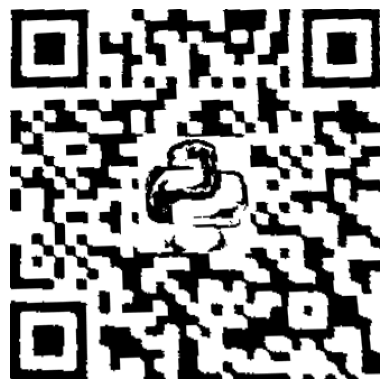

In [100]:
# cv2.getPerspectiveTransform - 정확히 점 4개 넣어주면 계산
mat, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC)
crop = cv2.warpPerspective(bin, mat, (330, 330))
plt.imshow(crop, cmap = 'gray')
plt.axis('off')
plt.show()

code = cv2.resize(crop, (33, 33)) > 128

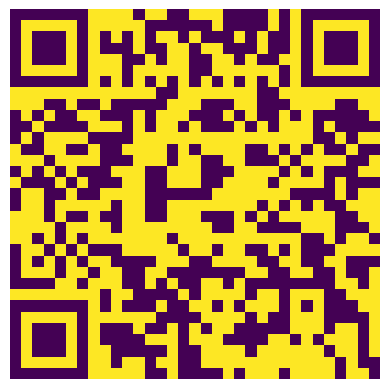

In [99]:
import matplotlib.pyplot as plt
plt.imshow(code)
plt.axis('off')
plt.show()